<a href="https://colab.research.google.com/github/yongxuantan/Python-for-atmospheric-science/blob/master/DiabeticDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diabetic Retinopathy Detection
### Kaggle link: https://www.kaggle.com/c/diabetic-retinopathy-detection/data

## Set Up:

### Change runtime - hardware accelerator to GUP. We have 25GB of RAM and 68 GB of disk space.


First, get data from Kaggle.
For details, go to: https://medium.com/@saedhussain/google-colaboratory-and-kaggle-datasets-b57a83eb6ef8

In [0]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

# install p7z for unzip
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [0]:
# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
# make directory to store kaggle key
!mkdir ~/.kaggle

# copy kaggle key over
!cp kaggle.json ~/.kaggle/

# adjust permission
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
# grab the specific files
!kaggle competitions download -c diabetic-retinopathy-detection -f train.zip.001
!kaggle competitions download -c diabetic-retinopathy-detection -f trainLabels.csv.zip

100% 7.81G/7.81G [02:51<00:00, 56.0MB/s]
100% 7.81G/7.81G [02:51<00:00, 48.9MB/s]
  0% 0.00/69.4k [00:00<?, ?B/s]
100% 69.4k/69.4k [00:00<00:00, 27.2MB/s]


In [0]:
# clear space along the way to make space

# unzip first, might take some time
!unzip train.zip.001.zip
!rm train.zip.001.zip

# unzip with p7z
!7zr x train.zip.001
!rm train.zip.001

# unzip with p7z again, might take an error on an image or two
!7z x train.zip
!rm train.zip

Archive:  train.zip.001.zip
  inflating: train.zip.001           

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 8388608000 bytes (8000 MiB)

Extracting archive: train.zip.001
  0% 1 Open           --
Path = train.zip.001
Type = Split
Physical Size = 8388608000
Volumes = 1
Total Physical Size = 8388608000

  0%      2% - train.zip                  4% - train.zip                  5% - train.zip                  6% - train.zip                  7% - train.zip                  8% - train.zip                  9% - train.zip      

In [0]:
# remove damaged images from step above
!rm train/194_right.jpeg

In [0]:
# take a look at result
!ls train

10003_left.jpeg   12448_left.jpeg   14788_left.jpeg   17158_left.jpeg
10003_right.jpeg  12448_right.jpeg  14788_right.jpeg  17158_right.jpeg
10007_left.jpeg   12450_left.jpeg   1478_left.jpeg    17163_left.jpeg
10007_right.jpeg  12450_right.jpeg  1478_right.jpeg   17163_right.jpeg
10009_left.jpeg   12451_left.jpeg   14793_left.jpeg   17169_left.jpeg
10009_right.jpeg  12451_right.jpeg  14793_right.jpeg  17169_right.jpeg
1000_left.jpeg	  12452_left.jpeg   14805_left.jpeg   17170_left.jpeg
1000_right.jpeg   12452_right.jpeg  14805_right.jpeg  17170_right.jpeg
10010_left.jpeg   12458_left.jpeg   14806_left.jpeg   17173_left.jpeg
10010_right.jpeg  12458_right.jpeg  14806_right.jpeg  17173_right.jpeg
10013_left.jpeg   12460_left.jpeg   14807_left.jpeg   17176_left.jpeg
10013_right.jpeg  12460_right.jpeg  14807_right.jpeg  17176_right.jpeg
10014_left.jpeg   12461_left.jpeg   1480_left.jpeg    17179_left.jpeg
10014_right.jpeg  12461_right.jpeg  1480_right.jpeg   17179_right.jpeg
10015_left.jpe

Import libraries:

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline 

import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from os import listdir
from PIL import Image
import keras
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [0]:
# image directory
filedir1 = "train"

# import labels
trainLabels = pd.read_csv('trainLabels.csv.zip', compression='zip', header=0, sep=',')

Adjust image size based on RAM size

In [0]:
#image_width=960;
#image_height=1440;
#image_width=640;
#image_height=960;
image_width=320;
image_height=320;
#image_width=128;
#image_height=128;
#image_width=256;
#image_height=256;

In [0]:
# other parameters:
batch_size = 32
num_classes = 5         
epoch = 30              # for multicategorical model
binary_epoch = 60       # for binary model

In [0]:
# import label
trainLabels = pd.read_csv('trainLabels.csv.zip', compression='zip', header=0, sep=',')
trainLabels

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
...,...,...
35121,44347_right,0
35122,44348_left,0
35123,44348_right,0
35124,44349_left,0


Import images: 
- Due to no symptom images much more available than symptom, we random keep half of the nosymptom images.
- Furthermore, we random argument images with symptom by vertical or horizontal flipping

In [0]:
# use for multicategorical model
train_image=[]
train_key=[]
test_image=[]
train_label=[]
test_key=[]
test_label=[]

# use for symptom / nosympton model
binary_image=[]
binary_key=[]

# import images with symptoms
cnt=0
for filename in listdir(filedir1):
  # get label
  l=trainLabels[trainLabels["image"]==filename.split(sep=".")[0]]["level"].iloc[0]

  # randomly drop half of the 0-labeled images
  half=random.random()
  if l>0 or half >= 0.5:
    print('processing ',cnt,'th image ',filename,' with label ',l)

    # import image using PIL Image, resize, then convert to numpy array
    # resize is done using PIL default NEAREST option
    im2=np.array(Image.open(filedir1+"/"+filename).resize((image_height,image_width)))

    binary_image.append(im2)
    if l>0:
      binary_key.append(1)
    else:
      binary_key.append(0)

    cnt+=1
    if cnt%5==0:
      test_image.append(im2)
      test_label.append(l)
      test_key.append([filename,l])
    else:
      train_image.append(im2)
      train_label.append(l)
      train_key.append([filename,l])

      # image argumentation
      if l>0:
        chance=random.random()
        if chance < 0.1:
          im3 = np.fliplr(im2)
          train_image.append(im3)
          train_label.append(l)
          train_key.append([filename,l])
        elif chance < 0.2:
          im3 = np.flipud(im2)
          train_image.append(im3)
          train_label.append(l)
          train_key.append([filename,l])

Streaming output truncated to the last 5000 lines.
processing  287 th image  13058_right.jpeg  with label  0
processing  288 th image  18378_left.jpeg  with label  0
processing  289 th image  19093_left.jpeg  with label  0
processing  290 th image  14311_right.jpeg  with label  0
processing  291 th image  16789_left.jpeg  with label  0
processing  292 th image  1140_right.jpeg  with label  2
processing  293 th image  14016_left.jpeg  with label  0
processing  294 th image  12882_left.jpeg  with label  0
processing  295 th image  12326_left.jpeg  with label  0
processing  296 th image  18100_left.jpeg  with label  0
processing  297 th image  10853_left.jpeg  with label  1
processing  298 th image  11547_right.jpeg  with label  1
processing  299 th image  16095_right.jpeg  with label  1
processing  300 th image  15351_left.jpeg  with label  0
processing  301 th image  12311_right.jpeg  with label  1
processing  302 th image  11159_left.jpeg  with label  2
processing  303 th image  14631_

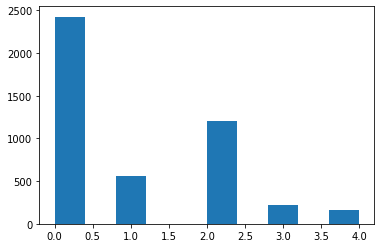

In [0]:
# check training data distribution
plt.hist(train_label)
plt.show()

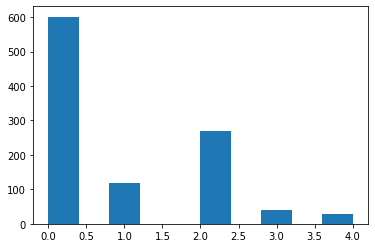

In [0]:
# check test data distribution
plt.hist(test_label)
plt.show()

In [0]:
# normalize image data
train_image=np.array(train_image).astype('float32') / 255
test_image=np.array(test_image).astype('float32') / 255

In [0]:
# Convert class vectors to binary class matrices.
train_label = keras.utils.to_categorical(train_label, num_classes)
test_label = keras.utils.to_categorical(test_label, num_classes)

In [0]:
print('train_image shape:', train_image.shape)
print(train_image.shape[0], 'train samples')
print(test_image.shape[0], 'test samples')

train_image shape: (4581, 320, 320, 3)
4581 train samples
1057 test samples


## First two models predict multiple classes, per competition require.

First model following MNIST example from class

In [0]:
model1 = models.Sequential()
model1.add(Conv2D(32, (3, 3), activation='relu', 
                  input_shape=(image_width,image_height,3)))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(Flatten())
model1.add(Dense(64, activation='relu'))
model1.add(Dense(num_classes, activation='softmax'))
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 318, 318, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 159, 159, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 157, 157, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 78, 78, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 76, 76, 64)        36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 369664)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)               

In [0]:
model1.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# train model
history1 = model1.fit(train_image, train_label, epochs=epoch, 
        validation_split=0.2, batch_size=batch_size, shuffle=True)

Train on 3664 samples, validate on 917 samples
Epoch 1/30
3664/3664 [==============================] - 10s 3ms/step - loss: 1.5325 - acc: 0.5098 - val_loss: 1.3451 - val_acc: 0.5202
Epoch 2/30
3664/3664 [==============================] - 10s 3ms/step - loss: 1.2229 - acc: 0.5276 - val_loss: 1.2183 - val_acc: 0.5202
Epoch 3/30
3664/3664 [==============================] - 10s 3ms/step - loss: 1.2127 - acc: 0.5273 - val_loss: 1.2199 - val_acc: 0.5278
Epoch 4/30
3664/3664 [==============================] - 10s 3ms/step - loss: 1.1998 - acc: 0.5338 - val_loss: 1.2114 - val_acc: 0.5202
Epoch 5/30
3664/3664 [==============================] - 10s 3ms/step - loss: 1.1759 - acc: 0.5371 - val_loss: 1.2347 - val_acc: 0.5278
Epoch 6/30
3664/3664 [==============================] - 10s 3ms/step - loss: 1.1643 - acc: 0.5398 - val_loss: 1.2713 - val_acc: 0.5256
Epoch 7/30
3664/3664 [==============================] - 10s 3ms/step - loss: 1.1448 - acc: 0.5489 - val_loss: 1.2372 - val_acc: 0.5256
Epoch 8/

In [0]:
# check model weights
model1.get_weights()

[array([[[[ 0.05201072, -0.08677107,  0.03130524,  0.09837867,
           -0.13920723, -0.21221513,  0.15751803, -0.09132864,
            0.0606054 , -0.06184433, -0.12688142,  0.12409332,
            0.06411062, -0.12606145,  0.11512301, -0.13506676,
           -0.1056622 , -0.13298275, -0.07368246, -0.02444127,
            0.03868842,  0.03502338, -0.03317112, -0.10795356,
           -0.10888533,  0.07814588, -0.13909447, -0.17094122,
           -0.0031558 ,  0.01714854, -0.09561675,  0.13335523],
          [ 0.16884877,  0.09703391, -0.11478149,  0.12504461,
           -0.16527723, -0.0879088 ,  0.05973037,  0.12222631,
            0.05107048,  0.09122119, -0.03419501, -0.04069314,
            0.01256668,  0.02523102, -0.15353648, -0.03995322,
            0.10006005, -0.12814215, -0.14386648,  0.02164443,
           -0.09725527,  0.03879537, -0.1400709 ,  0.12238113,
            0.11524107,  0.07389776,  0.00471199, -0.03118155,
           -0.13145514,  0.11730539, -0.058573  ,  0.0

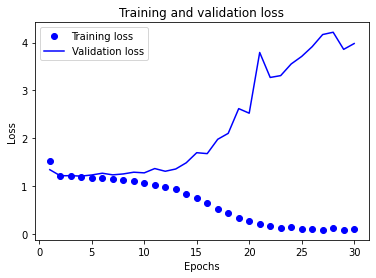

In [0]:
# show training loss
acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

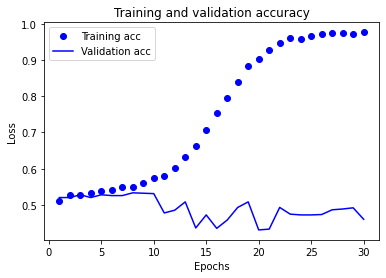

In [0]:
# show training accuracy
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [0]:
# apply model to compare result with true label
model1_pred = model1.predict(test_image)
np.round(model1_pred[:10]).tolist()

[[1.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, 0.0]]

In [0]:
test_label[:10]

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [0]:
# check model accuracy for all test data
test_loss, test_acc = model1.evaluate(test_image, test_label)
test_acc

1057/1057 [==============================] - 1s 1ms/step


0.5070955534531694

Second model following CiFAR example from class

In [0]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=train_image.shape[1:]))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes, activation='softmax'))
model2.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 320, 320, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 320, 320, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 318, 318, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 159, 159, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 159, 159, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 159, 159, 64)      18496     
____

In [0]:
# For a multi-class classification problem
model2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# train model
history2 = model2.fit(train_image, train_label, batch_size=batch_size, 
                  validation_split=0.2, epochs=epoch, shuffle=True)

Train on 3664 samples, validate on 917 samples
Epoch 1/30
3664/3664 [==============================] - 28s 8ms/step - loss: 1.5713 - acc: 0.5172 - val_loss: 1.2940 - val_acc: 0.5202
Epoch 2/30
3664/3664 [==============================] - 23s 6ms/step - loss: 1.2405 - acc: 0.5287 - val_loss: 1.2323 - val_acc: 0.5202
Epoch 3/30
3664/3664 [==============================] - 23s 6ms/step - loss: 1.2348 - acc: 0.5300 - val_loss: 1.2422 - val_acc: 0.5202
Epoch 4/30
3664/3664 [==============================] - 23s 6ms/step - loss: 1.2422 - acc: 0.5325 - val_loss: 1.2209 - val_acc: 0.5202
Epoch 5/30
3664/3664 [==============================] - 23s 6ms/step - loss: 1.2139 - acc: 0.5311 - val_loss: 1.2206 - val_acc: 0.5202
Epoch 6/30
3664/3664 [==============================] - 23s 6ms/step - loss: 1.1981 - acc: 0.5322 - val_loss: 1.2685 - val_acc: 0.5202
Epoch 7/30
3664/3664 [==============================] - 23s 6ms/step - loss: 1.1918 - acc: 0.5322 - val_loss: 1.2195 - val_acc: 0.5202
Epoch 8/

In [0]:
# check model weights
model2.get_weights()

[array([[[[ 1.44996345e-01, -4.22497019e-02, -1.25346938e-02,
            4.28183526e-02, -8.76690671e-02, -1.32069230e-01,
            8.66412744e-02, -1.12855189e-01, -3.63376066e-02,
           -3.15552428e-02, -7.30839297e-02,  2.62611937e-02,
           -5.83615862e-02, -1.36494890e-01, -2.90554650e-02,
           -1.50351226e-01,  1.94766875e-02,  9.05110911e-02,
           -1.14741206e-01, -2.87184455e-02, -4.48972434e-02,
           -2.90526403e-03,  9.87005085e-02, -2.37966441e-02,
            3.08127142e-02,  7.27388891e-04, -1.32056966e-01,
            3.33264619e-02, -1.20952576e-02, -7.01901540e-02,
            9.55718085e-02, -5.94060980e-02],
          [-4.18084227e-02, -5.58036705e-03,  1.06508277e-01,
           -1.45659119e-01,  1.33445740e-01, -1.21780755e-02,
           -1.40063360e-01, -1.36519313e-01, -8.58712718e-02,
           -2.33548582e-02, -1.03905655e-01,  7.44251013e-02,
           -7.26979375e-02, -4.27774712e-02, -4.76710275e-02,
            4.91936579e-

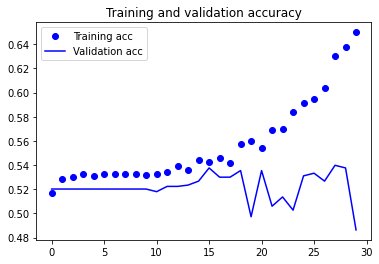

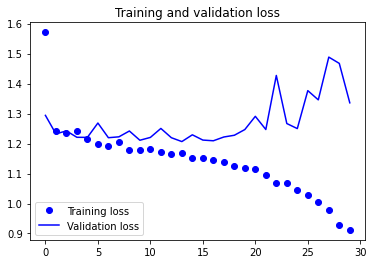

In [0]:
# show training loss and accuracy
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# compare prediction against true label
model2_pred = model2.predict(test_image)
np.round(model2_pred[:10]).tolist()

[[0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0]]

In [0]:
test_label[:10]

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [0]:
# Score trained model.
scores = model2.evaluate(test_image, test_label, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

1057/1057 [==============================] - 2s 2ms/step
Test loss: 1.2858124677595826
Test accuracy: 0.533585619678335


This next model had parameters adjusted to avoid saddle points

In [0]:
model2_1 = Sequential()
model2_1.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=train_image.shape[1:],
                kernel_initializer='random_uniform'))
model2_1.add(Activation('relu'))
model2_1.add(Conv2D(32, (3, 3), activation='relu'))
model2_1.add(MaxPooling2D(pool_size=(2, 2)))
model2_1.add(Dropout(0.25))

model2_1.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model2_1.add(Conv2D(64, (3, 3), activation='relu',
                kernel_initializer='random_uniform'))
model2_1.add(MaxPooling2D(pool_size=(2, 2)))
model2_1.add(Dropout(0.25))

model2_1.add(Flatten())
model2_1.add(Dense(512, activation='relu'))
model2_1.add(Dropout(0.5))
model2_1.add(Dense(num_classes, activation='softmax'))
model2_1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 320, 320, 32)      896       
_________________________________________________________________
activation_2 (Activation)    (None, 320, 320, 32)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 318, 318, 32)      9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 159, 159, 32)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 159, 159, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 159, 159, 64)      18496     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 157, 157, 64)     

In [0]:
from keras import optimizers
# For a multi-class classification problem
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model2_1.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# train model
history2_1 = model2_1.fit(train_image, train_label, batch_size=batch_size, 
                  validation_split=0.2, epochs=epoch, shuffle=True)

Train on 3664 samples, validate on 917 samples
Epoch 1/30
3664/3664 [==============================] - 24s 7ms/step - loss: 1.2593 - acc: 0.5251 - val_loss: 1.3745 - val_acc: 0.5202
Epoch 2/30
3664/3664 [==============================] - 21s 6ms/step - loss: 1.2390 - acc: 0.5308 - val_loss: 1.2424 - val_acc: 0.5202
Epoch 3/30
3664/3664 [==============================] - 21s 6ms/step - loss: 1.2211 - acc: 0.5319 - val_loss: 1.2333 - val_acc: 0.5202
Epoch 4/30
3664/3664 [==============================] - 21s 6ms/step - loss: 1.2293 - acc: 0.5319 - val_loss: 1.2320 - val_acc: 0.5202
Epoch 5/30
3664/3664 [==============================] - 21s 6ms/step - loss: 1.2210 - acc: 0.5322 - val_loss: 1.2284 - val_acc: 0.5202
Epoch 6/30
3664/3664 [==============================] - 21s 6ms/step - loss: 1.2154 - acc: 0.5322 - val_loss: 1.2323 - val_acc: 0.5202
Epoch 7/30
3664/3664 [==============================] - 21s 6ms/step - loss: 1.2087 - acc: 0.5322 - val_loss: 1.2283 - val_acc: 0.5202
Epoch 8/

In [0]:
# check model weights
model2_1.get_weights()

[array([[[[ 9.58818477e-03, -5.70250489e-02,  4.40249033e-03,
            4.55348333e-03, -4.45864350e-02, -3.66845690e-02,
           -3.69499363e-02,  3.63149643e-02, -6.22273274e-02,
            2.90561561e-02, -4.17306758e-02, -1.84943564e-02,
           -3.52836959e-02, -2.48609465e-02,  1.73623655e-02,
            2.45129839e-02,  3.48472521e-02,  1.07232416e-02,
            4.09335904e-02,  4.03154492e-02, -3.82216871e-02,
           -4.22102809e-02, -2.24134922e-02,  3.95094557e-03,
           -4.37935479e-02, -1.95350708e-03, -8.38066358e-03,
           -2.58271731e-02,  3.93526852e-02, -4.16475683e-02,
            9.51092411e-03,  4.48518954e-02],
          [ 2.68004555e-02,  2.55775289e-03,  1.48627302e-02,
            1.09348474e-02, -3.26063186e-02, -2.67134216e-02,
           -2.50164513e-02, -2.48518251e-02,  2.68153735e-02,
            2.15563383e-02, -2.12984718e-02, -2.47091074e-02,
           -5.14799729e-02, -5.46198636e-02, -3.58374305e-02,
            3.16482931e-

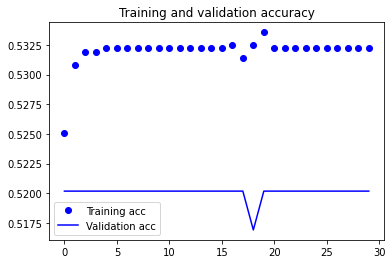

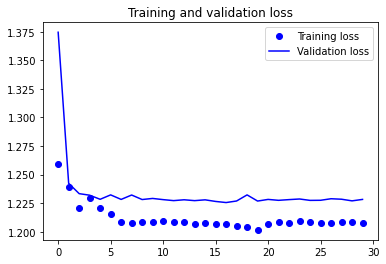

In [0]:
# show training loss and accuracy
acc = history2_1.history['acc']
val_acc = history2_1.history['val_acc']
loss = history2_1.history['loss']
val_loss = history2_1.history['val_loss']

epochs = range(len(acc))

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# compare prediction against true label
model2_1pred = model2_1.predict(test_image)
np.round(model2_1pred[:10]).tolist()
#model2_1pred[:10].tolist()

[[1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0]]

In [0]:
test_label[:10]

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [0]:
# Score trained model.
scores = model2_1.evaluate(test_image, test_label, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

1057/1057 [==============================] - 2s 2ms/step
Test loss: 1.139692838843859
Test accuracy: 0.5685903500473037


## Next two models predict symptom/no symptom. Effectively turn into binary prediction.

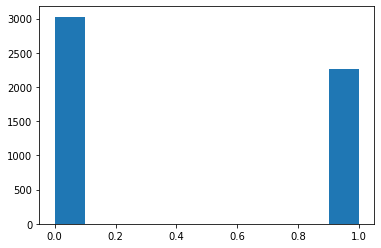

In [0]:
# look at binary data distribution
plt.hist(binary_key)
plt.show()

In [0]:
# split data into training and testing, shuffle is automatically applied
train_image,test_image,train_label,test_label=train_test_split(binary_image,binary_key,test_size=0.2)

In [0]:
# normalization
train_image = np.array(train_image).astype('float32')/255
test_image = np.array(test_image).astype('float32')/255

Third model follow same design as first model

In [0]:
model3 = models.Sequential()
model3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_width,image_height,3)))
model3.add(MaxPooling2D((2, 2)))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(Flatten())
model3.add(Dense(64, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))
model3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 318, 318, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 159, 159, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 157, 157, 64)      18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 78, 78, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 76, 76, 64)        36928     
_________________________________________________________________
flatten_7 (Flatten)          (None, 369664)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)               

In [0]:
model3.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [0]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
# train model, stop if 20 epochs do not show improvement

history3 = model3.fit(train_image, train_label, epochs=binary_epoch, 
            validation_split=0.2, batch_size=batch_size, shuffle=True, callbacks=[es_callback])

Train on 3382 samples, validate on 846 samples
Epoch 1/60
3382/3382 [==============================] - 10s 3ms/step - loss: 7.0123 - binary_accuracy: 0.5618 - val_loss: 6.2831 - val_binary_accuracy: 0.6099
Epoch 2/60
3382/3382 [==============================] - 9s 3ms/step - loss: 7.0630 - binary_accuracy: 0.5618 - val_loss: 6.2831 - val_binary_accuracy: 0.6099
Epoch 3/60
3382/3382 [==============================] - 9s 3ms/step - loss: 7.0630 - binary_accuracy: 0.5618 - val_loss: 6.2831 - val_binary_accuracy: 0.6099
Epoch 4/60
3382/3382 [==============================] - 9s 3ms/step - loss: 7.0630 - binary_accuracy: 0.5618 - val_loss: 6.2831 - val_binary_accuracy: 0.6099
Epoch 5/60
3382/3382 [==============================] - 9s 3ms/step - loss: 7.0630 - binary_accuracy: 0.5618 - val_loss: 6.2831 - val_binary_accuracy: 0.6099
Epoch 6/60
3382/3382 [==============================] - 9s 3ms/step - loss: 7.0630 - binary_accuracy: 0.5618 - val_loss: 6.2831 - val_binary_accuracy: 0.6099
Epoc

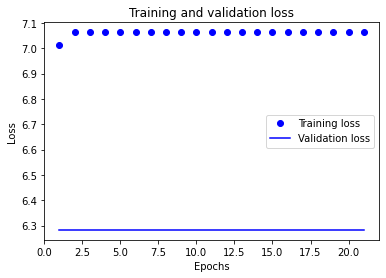

In [0]:
# show training loss and accuracy
acc = history3.history['binary_accuracy']
val_acc = history3.history['val_binary_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

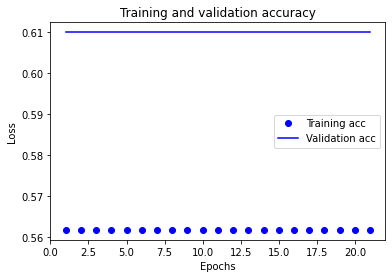

In [0]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [0]:
# compare prediction against true label
model3_pred = model3.predict(test_image)
#np.round(model3_pred[:10]).tolist()
model3_pred[:10].tolist()

[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]

In [0]:
test_label[:10]

[0, 1, 1, 1, 1, 1, 0, 0, 1, 0]

In [0]:
results = model3.evaluate(test_image, test_label)
print('Test loss:', results[0])
print('Test accuracy:', results[1])

1058/1058 [==============================] - 1s 1ms/step
Test loss: 6.794584761233515
Test accuracy: 0.5784499054820416


Fourth model follows second model

In [0]:
model4 = Sequential()
model4.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=train_image.shape[1:]))
model4.add(Activation('relu'))
model4.add(Conv2D(32, (3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))

model4.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model4.add(Conv2D(64, (3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))

model4.add(Flatten())
model4.add(Dense(64, activation='relu'))
model4.add(Dense(1, activation='sigmoid'))
model4.summary

<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x7f5ff2651f98>>

In [0]:
model4.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [0]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
# train model, stop if 20 epochs do not show improvement
history4 = model4.fit(train_image, train_label, epochs=binary_epoch, validation_split=0.2, 
                      batch_size=batch_size, shuffle=True, callbacks=[es_callback])

Train on 3382 samples, validate on 846 samples
Epoch 1/60
3382/3382 [==============================] - 17s 5ms/step - loss: 7.0124 - binary_accuracy: 0.5612 - val_loss: 6.2872 - val_binary_accuracy: 0.6099
Epoch 2/60
3382/3382 [==============================] - 16s 5ms/step - loss: 7.0630 - binary_accuracy: 0.5618 - val_loss: 6.2872 - val_binary_accuracy: 0.6099
Epoch 3/60
3382/3382 [==============================] - 16s 5ms/step - loss: 7.0630 - binary_accuracy: 0.5618 - val_loss: 6.2872 - val_binary_accuracy: 0.6099
Epoch 4/60
3382/3382 [==============================] - 16s 5ms/step - loss: 7.0630 - binary_accuracy: 0.5618 - val_loss: 6.2872 - val_binary_accuracy: 0.6099
Epoch 5/60
3382/3382 [==============================] - 16s 5ms/step - loss: 7.0630 - binary_accuracy: 0.5618 - val_loss: 6.2872 - val_binary_accuracy: 0.6099
Epoch 6/60
3382/3382 [==============================] - 16s 5ms/step - loss: 7.0630 - binary_accuracy: 0.5618 - val_loss: 6.2872 - val_binary_accuracy: 0.6099

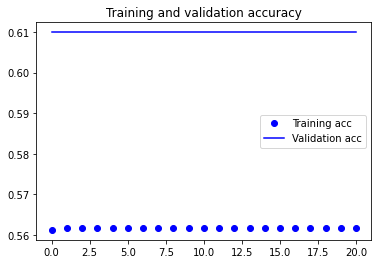

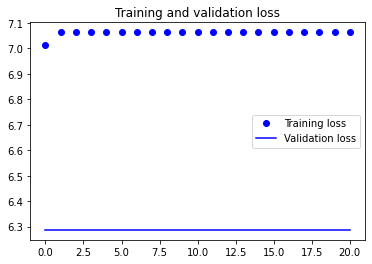

In [0]:
# show training loss and accuracy
acc = history4.history['binary_accuracy']
val_acc = history4.history['val_binary_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(len(acc))

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# compare prediction to true label
model4_pred = model4.predict(test_image)
#np.round(model4_pred[:10]).tolist()
model4_pred[:10].tolist()

[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]

In [0]:
test_label[:10]

[0, 1, 1, 1, 1, 1, 0, 0, 1, 0]

In [0]:
results = model4.evaluate(test_image, test_label)
print('Test loss:', results[0])
print('Test accuracy:', results[1])

1058/1058 [==============================] - 2s 2ms/step
Test loss: 6.794584761233515
Test accuracy: 0.5784499054820416


This models had parameters adjusted to avoid overfitting

In [0]:
from keras.constraints import max_norm
from keras import regularizers

In [0]:
model4_1 = Sequential()
model4_1.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=train_image.shape[1:],
                kernel_regularizer=regularizers.l2(0.001)))
model4_1.add(Activation('relu'))
model4_1.add(Conv2D(32, (3, 3), activation='relu', 
            kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
model4_1.add(MaxPooling2D(pool_size=(2, 2)))
model4_1.add(Dropout(0.25))

model4_1.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model4_1.add(Conv2D(64, (3, 3), activation='relu'))
model4_1.add(MaxPooling2D(pool_size=(2, 2)))
model4_1.add(Dropout(0.25))

model4_1.add(Flatten())
model4_1.add(Dense(64, activation='relu', kernel_constraint=max_norm(3)))
model4_1.add(Dense(1, activation='sigmoid'))
model4_1.summary

<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x7f5ff24b3d30>>

In [0]:
model4_1.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [0]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
# train model, stop if 20 epochs do not show improvement
history4_1 = model4_1.fit(train_image, train_label, epochs=binary_epoch, validation_split=0.2, 
                      batch_size=batch_size, shuffle=True, callbacks=[es_callback])

Train on 3382 samples, validate on 846 samples
Epoch 1/60
3382/3382 [==============================] - 18s 5ms/step - loss: 0.9511 - binary_accuracy: 0.5556 - val_loss: 0.6876 - val_binary_accuracy: 0.6099
Epoch 2/60
3382/3382 [==============================] - 16s 5ms/step - loss: 0.6958 - binary_accuracy: 0.5588 - val_loss: 0.6808 - val_binary_accuracy: 0.6099
Epoch 3/60
3382/3382 [==============================] - 16s 5ms/step - loss: 0.7065 - binary_accuracy: 0.5580 - val_loss: 0.6773 - val_binary_accuracy: 0.6099
Epoch 4/60
3382/3382 [==============================] - 16s 5ms/step - loss: 0.6925 - binary_accuracy: 0.5597 - val_loss: 0.6893 - val_binary_accuracy: 0.6099
Epoch 5/60
3382/3382 [==============================] - 16s 5ms/step - loss: 0.6899 - binary_accuracy: 0.5591 - val_loss: 0.6831 - val_binary_accuracy: 0.6099
Epoch 6/60
3382/3382 [==============================] - 16s 5ms/step - loss: 0.6882 - binary_accuracy: 0.5582 - val_loss: 0.7017 - val_binary_accuracy: 0.6099

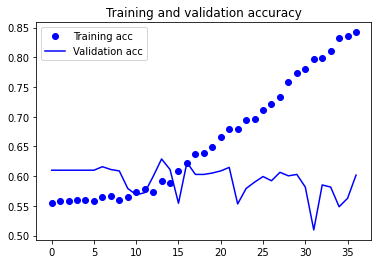

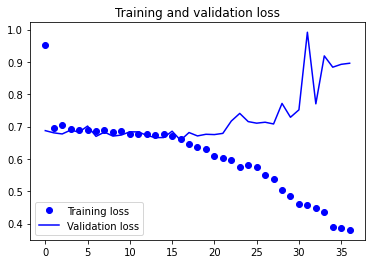

In [0]:
# show training loss and accuracy
acc = history4_1.history['binary_accuracy']
val_acc = history4_1.history['val_binary_accuracy']
loss = history4_1.history['loss']
val_loss = history4_1.history['val_loss']

epochs = range(len(acc))

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# compare prediction to true label
model4_1pred = model4_1.predict(test_image)
np.round(model4_1pred[:10]).tolist()

[[0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0]]

In [0]:
test_label[:10]

[0, 1, 1, 1, 1, 1, 0, 0, 1, 0]

In [0]:
results = model4_1.evaluate(test_image, test_label)
print('Test loss:', results[0])
print('Test accuracy:', results[1])

1058/1058 [==============================] - 2s 2ms/step
Test loss: 0.9490032613502783
Test accuracy: 0.5718336483931947
